In [4]:
import requests
import json
import math
import os
import re
import sys
import csv
import hashlib
import numpy as np
from datetime import datetime, timedelta
from dateutil import parser
from itertools import combinations
from collections import Counter, defaultdict
from urllib import parse

import django
from django.db.models import Count, Q

from PIL import Image
from PIL.Image import Image as ImageType
from io import BytesIO
from bs4 import BeautifulSoup
from skimage import data, img_as_float
from fuzzywuzzy import fuzz
from Levenshtein import distance
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from flat_crawler.models import FlatPost, Flat, Source, ImageMatch, PostHash, Location, SearchArea
from flat_crawler.constants import SELECTED_DISTRICTS, THUMBNAIL_SIZE, CITY_WARSAW
from flat_crawler.utils.img_utils import bytes_to_images, get_img_bytes_from_url
from flat_crawler.utils.img_matching import ImageMatchingEngine
from flat_crawler.utils.flat_post_matcher import ImageMatcher
from flat_crawler.utils.location import get_district_local_name
from flat_crawler.utils.text_utils import simplify_text


GUMTREE_URL = "https://www.gumtree.pl/s-mieszkania-i-domy-sprzedam-i-kupie/srodmiescie/v1c9073l3200017p1?pr=450000,1000000"

In [2]:
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [3]:
%load_ext autoreload
%autoreload 2

In [20]:
sm_poly = Polygon(SearchArea.objects.get(name='stary-mokotow').points)
base_poly = Polygon(SearchArea.objects.get(name='base-area').points)

In [21]:
for loc in Location.objects.all():
    if loc.lat is None or loc.lng is None:
        continue
    loc_p = Point(loc.lng, loc.lat)
    if base_poly.contains(loc_p):
        print(loc.full_name)

ulica gen. Władysława Andersa
ulica Balladyny
Plac Bankowy
ulica Belwederska
ulica Bukietowa
ulica Chmielna
ulica Ciasna
Plac Jana Henryka Dąbrowskiego
ulica Jarosława Dąbrowskiego
ulica Dymińska
ulica Elektoralna
ulica Jurija Gagarina
ulica Mahatmy Gandhiego
Plac Grzybowski
ulica Hoża
Plac Inwalidów
Aleja Jana Pawła II
Skwer Tadeusza Kahla
ulica Karmelicka
Plac Konstytucji
ulica Mikołaja Kopernika
ulica Kredytowa
ulica Króżańska
ulica Krucza
ulica Antoniego Józefa Madalińskiego
Aleja 3 Maja
ulica Marszałkowska
ulica Miła
Plac Mirowski
ulica Morskie Oko
ulica Ludwika Narbutta
Aleja Niepodległości
ulica Niska
ulica Nowogrodzka
ulica Nowolipie
ulica Antoniego Edwarda Odyńca
Rondo Organizacji Narodów Zjednoczonych
ulica Parkowa
ulica Potocka
ulica Próżna
ulica Rakowiecka
Skwer Antoniego Słonimskiego
ulica Solec
Rynek Starego Miasta
ulica Świętokrzyska
ulica Romualda Traugutta
Plac Trzech Krzyży
Plac Unii Lubelskiej
ulica Wilcza
Plac Thomasa Woodrowa Wilsona
ulica Włościańska
ulica Wspólna

### Crawl Otodom

In [5]:
details_req = requests.get('https://www.otodom.pl/pl/oferta/klimatyczne-dwupokojowe-w-kamienicy-na-muranowie-ID49RpO.html#a841f3bc7a')
soup = BeautifulSoup(details_req.content)

/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.location' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.posthash' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.flat' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_la

In [14]:
print(soup.find(id="__next").prettify())

<div id="__next">
 <style data-emotion="css-global 7t7tz7">
  @font-face{font-family:'Open Sans';src:url('https://statics.otodom.pl/fp_statics/fonts/OpenSans/Regular.ttf');font-weight:400;font-display:swap;}@font-face{font-family:'Open Sans';src:url('https://statics.otodom.pl/fp_statics/fonts/OpenSans/SemiBold.ttf');font-weight:600;font-display:swap;}@font-face{font-family:'Open Sans';src:url('https://statics.otodom.pl/fp_statics/fonts/OpenSans/Bold.ttf');font-weight:700;font-display:swap;}
 </style>
 <style data-emotion="css-global h9vlxl">
  *,*::after,*::before{box-sizing:border-box;}body{margin:0;padding:0;background-color:#fff;color:#1b232e;font-family:Open Sans,Arial,sans-serif;font-size:14px;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale;line-height:calc(20 / 14);}input,textarea,button{font-family:inherit;}
 </style>
 <style data-emotion="css f9edtv">
  .css-f9edtv{display:-webkit-box;display:-webkit-flex;display:-ms-flexbox;display:flex;position:relative;w

## Utils

In [130]:
def display_img_comp(img1, img2, **sims):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for img, ax in zip([img1, img2], axes.ravel()):
        ax.imshow(img)
        ax.axis('off')
    for i, (name, s) in enumerate(sims.items()):
        ax.text(200, (i + 1) * 30, f"{name}: {s:.2}", fontsize=15)
    fig.tight_layout()
    

In [131]:
def display_images(images):
    S = math.ceil(len(images) ** 0.5)
    fig = plt.figure(figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(S, S),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    
    ext_images = images + [None] * (S ** 2 - len(images))

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        if im is not None:
            ax.imshow(im)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [132]:
def display_post_images(post):
    display_images(bytes_to_images(post.photos_bytes))

In [52]:
def text_sim(t1, t2):
    return -distance(t1, t2)

In [123]:
sizes_dict = defaultdict(list)
for fp in FlatPost.objects.all():
    if fp.flat is not None and fp.size_m2 is not None and fp.desc is not None:
        sizes_dict[int(fp.size_m2)].append((fp, fp.desc.lower()))

In [124]:
results = []

In [125]:
for size, fptxts in sizes_dict.items():
    for (fp1, t1), (fp2, t2) in combinations(fptxts, 2):
        if fp1.flat != fp2.flat:
            results.append((-distance(t1, t2), t1, t2, fp1, fp2))
            

KeyboardInterrupt: 

In [127]:
results.sort(reverse=True, key=lambda x: x[0])

0 True



/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


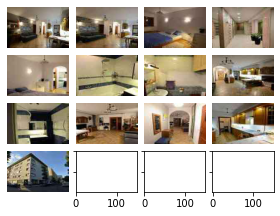

-------------------------------------


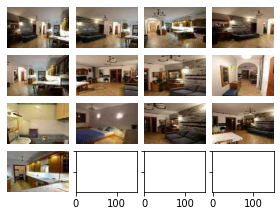

******************
******************
******************
-90 True



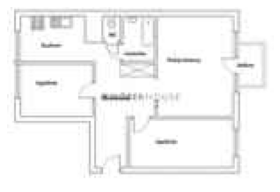

-------------------------------------


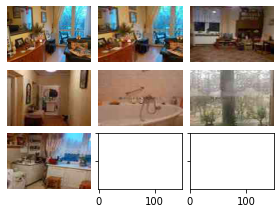

******************
******************
******************
-90 True



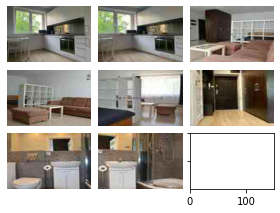

-------------------------------------


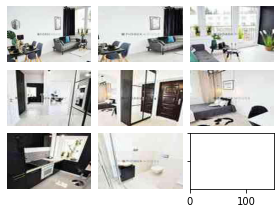

******************
******************
******************
-102 True



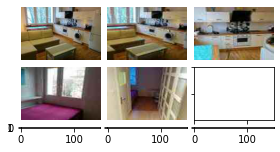

-------------------------------------


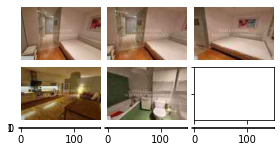

******************
******************
******************
-105 True



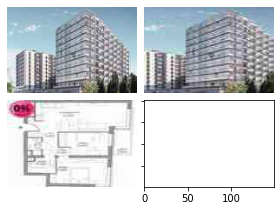

-------------------------------------


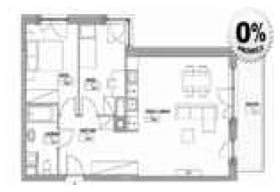

******************
******************
******************
-106 True



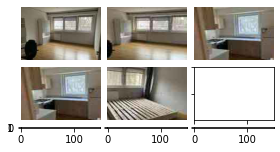

-------------------------------------


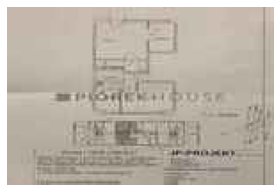

******************
******************
******************
-108 True



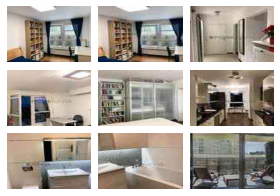

-------------------------------------


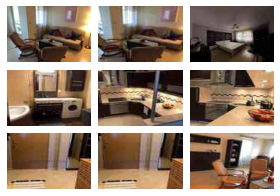

******************
******************
******************
-111 True



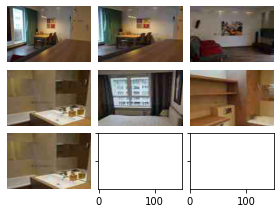

-------------------------------------


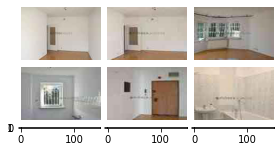

******************
******************
******************
-113 True



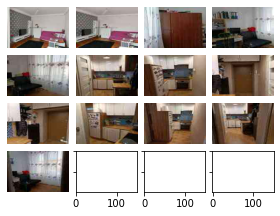

-------------------------------------


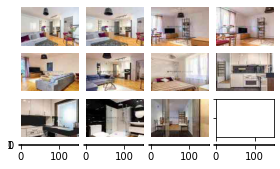

******************
******************
******************
-113 True



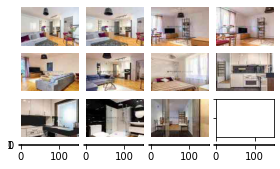

-------------------------------------


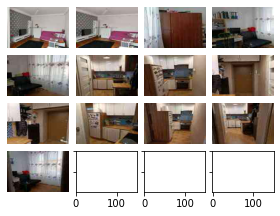

******************
******************
******************


In [133]:
for sim, t1, t2, fp1, fp2 in results[:10]:
    print(sim, fp1.flat != fp2.flat)
    print("")
    display_post_images(fp1)
    print("-------------------------------------")
    display_post_images(fp2)
    print("******************")
    print("******************")
    print("******************")

### Geo

In [20]:
query = Q()
sel_dlocs = set()
for dist in SELECTED_DISTRICTS:
    dloc = get_district_local_name(dist)
    sel_dlocs.add(dloc)
    query = query | Q(districts_local_names__contains=dloc)

In [19]:
sel_dlocs

{'Bielany', 'Mokotów', 'Ochota', 'Śródmieście', 'Żoliborz'}

In [27]:
for l in Location.objects.filter(query).values_list('districts_local_names', flat=True):
    if not len(set(map(lambda x: x.strip(), l.split(','))) & sel_dlocs):
        print(l)

In [34]:
parse.quote("Warszawa, ul. Świętokrzyska")

'Warszawa%2C%20ul.%20%C5%9Awi%C4%99tokrzyska'

In [35]:
with open('gapi.key', 'r') as f:
    api_key = f.read().strip('\n')

In [37]:
def get_resp_json(address, api_key):
    enc_address = parse.quote(address)
    req_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={enc_address}&key={api_key}'
    resp = requests.get(req_url)
    return resp.json()

In [32]:
def get_location_query(location):
    query_elems = ['Warszawa']
    districts = location.districts_local_names.split(',')
    if len(districts) == 1:
        query_elems.append(districts[0])
    query_elems.append(location.full_name)
    query_str = parse.quote(','.join(query_elems))
    return query_str

In [51]:
len(set(loc for fp in FlatPost.objects.annotate(num_locations=Count('locations')).filter(num_locations__gt=0).all() for loc in fp.locations.all()))


26

In [34]:
get_location_query(loc)

'Warszawa%2CRondo%20Organizacji%20Narod%C3%B3w%20Zjednoczonych'

In [36]:
def fetch_location_geo(location):
    if location.geolocation_data is not None:
        return
    query_str = get_location_query(location)
    if query_str:
        req_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={query_str}&key={api_key}'
        resp = requests.get(req_url)
        if resp.ok:
            location.geolocation_data = resp.json()
            location.save()
            return resp.json()

In [55]:
Location.objects.annotate(num_posts=Count('flatpost')).filter(num_posts__gt=0, geolocation_data__isnull=True).count()

0

In [56]:
gd = Location.objects.filter(geolocation_data__isnull=False)[0].geolocation_data

/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.location' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.posthash' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/django/db/models/base.py:321: RuntimeWarning: Model 'flat_crawler.flat' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_la

In [62]:
res = gd['results'][0]

In [65]:
res['geometry']

{'bounds': {'northeast': {'lat': 52.2587299, 'lng': 21.0039439},
  'southwest': {'lat': 52.2443329, 'lng': 20.9944845}},
 'location': {'lat': 52.2519594, 'lng': 20.998101},
 'location_type': 'GEOMETRIC_CENTER',
 'viewport': {'northeast': {'lat': 52.2587299, 'lng': 21.0039439},
  'southwest': {'lat': 52.2443329, 'lng': 20.9944845}}}

In [37]:
fetch_location_geo(loc)

{'results': [{'address_components': [{'long_name': 'rondo ONZ',
     'short_name': 'rondo ONZ',
     'types': ['route']},
    {'long_name': 'Warszawa',
     'short_name': 'Warszawa',
     'types': ['locality', 'political']},
    {'long_name': 'Warszawa',
     'short_name': 'Warszawa',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Mazowieckie',
     'short_name': 'Mazowieckie',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'Poland',
     'short_name': 'PL',
     'types': ['country', 'political']},
    {'long_name': '00-824', 'short_name': '00-824', 'types': ['postal_code']}],
   'formatted_address': 'rondo ONZ, 00-824 Warszawa, Poland',
   'geometry': {'bounds': {'northeast': {'lat': 52.2335224, 'lng': 20.9989701},
     'southwest': {'lat': 52.2326773, 'lng': 20.9975415}},
    'location': {'lat': 52.2332215, 'lng': 20.9987368},
    'location_type': 'GEOMETRIC_CENTER',
    'viewport': {'northeast': {'lat': 52.234448830291

In [20]:
req_url = f'https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA&key={api_key}'

In [21]:
resp = requests.get(req_url)

In [44]:
resp.json()['results'][0]['geometry']['viewport']

{'northeast': {'lat': 37.42364398029149, 'lng': -122.0827990197085},
 'southwest': {'lat': 37.4209460197085, 'lng': -122.0854969802915}}

In [46]:
get_resp_json('Warszawa, Wesoła, Żytnia', api_key)

{'results': [{'address_components': [{'long_name': 'Żytnia',
     'short_name': 'Żytnia',
     'types': ['route']},
    {'long_name': 'Wesoła',
     'short_name': 'Wesoła',
     'types': ['political', 'sublocality', 'sublocality_level_1']},
    {'long_name': 'Warszawa',
     'short_name': 'Warszawa',
     'types': ['locality', 'political']},
    {'long_name': 'Warszawa',
     'short_name': 'Warszawa',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Mazowieckie',
     'short_name': 'Mazowieckie',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'Poland',
     'short_name': 'PL',
     'types': ['country', 'political']},
    {'long_name': '05-075', 'short_name': '05-075', 'types': ['postal_code']}],
   'formatted_address': 'Żytnia, 05-075 Warszawa, Poland',
   'geometry': {'bounds': {'northeast': {'lat': 52.2450652, 'lng': 21.1943182},
     'southwest': {'lat': 52.2428495, 'lng': 21.1933499}},
    'location': {'lat': 52.2439324

### Image comparison

In [7]:
img_url_x = 'https://ireland.apollo.olxcdn.com/v1/files/eyJmbiI6InY3eDRpb2txOTh5djEtQVBMIiwidyI6W3siZm4iOiJqMWozbzEzbTZiZ24xLUFQTCIsInMiOiIxNCIsInAiOiIxMCwtMTAiLCJhIjoiMCJ9XX0.eVJ1XzpPLIOIq8rr_WyNvAmGWFp7tuXslKJPirxlhq8/image;s=1280x1024;q=80'
img_url_a = 'https://i.ebayimg.com/00/s/NjgzWDEwMjQ=/z/3H8AAOSwFu1gDFCC/$_20.JPG'
img_url_b = 'https://ireland.apollo.olxcdn.com/v1/files/eyJmbiI6ImZ6NjVxeThpeWc0MjEtQVBMIiwidyI6W3siZm4iOiJqMWozbzEzbTZiZ24xLUFQTCIsInMiOiIxNCIsInAiOiIxMCwtMTAiLCJhIjoiMCJ9XX0.qD3I6cCpP0jAL3Aq96dpMZM_CAsuYmgSBwm6U9Az4pE/image;s=1280x1024;q=80'

In [33]:
im_a = Image.open(BytesIO(requests.get(img_url_a).content))
im_b = Image.open(BytesIO(requests.get(img_url_b).content))
im_x = Image.open(BytesIO(requests.get(img_url_x).content))

In [8]:
im_a = Image.open(BytesIO(requests.get(img_url_a).content))

In [11]:
S = (150, 100)

/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


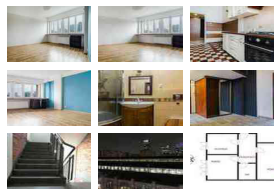

In [162]:
display_post_images(FlatPost.objects.all()[0])

### Results of image matching

/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


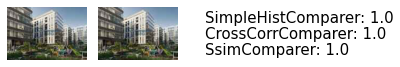

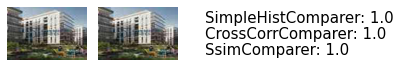

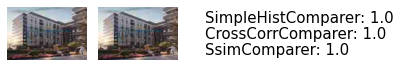

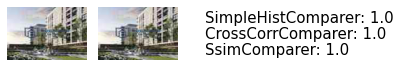

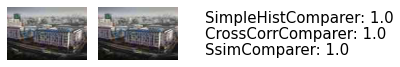

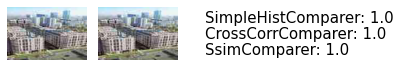

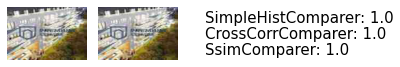

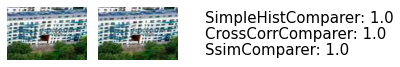

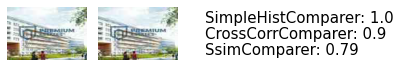

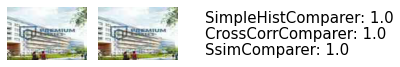

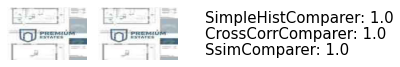

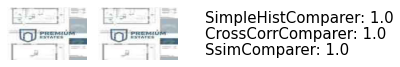

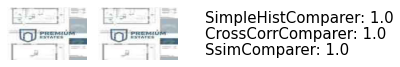

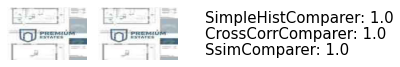

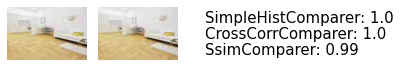

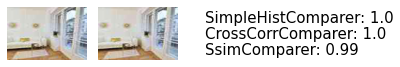

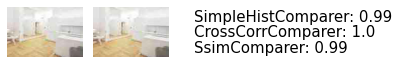

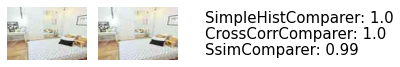

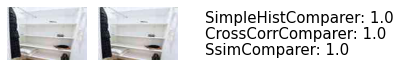

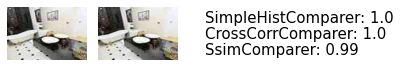

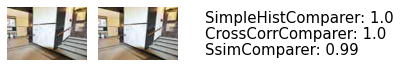

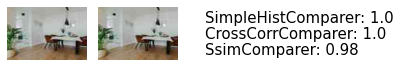

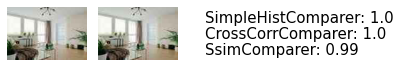

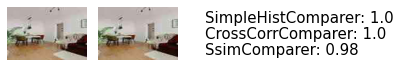

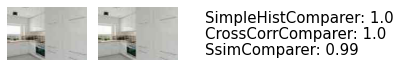

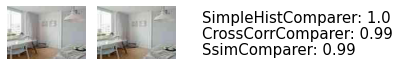

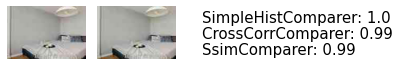

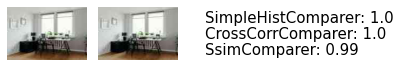

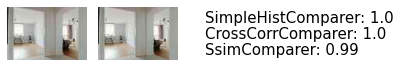

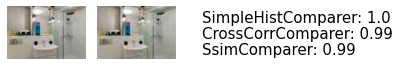

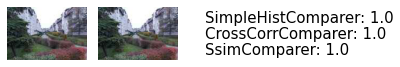

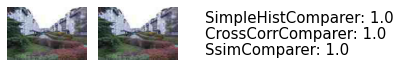

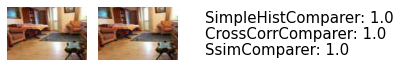

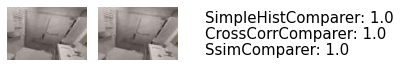

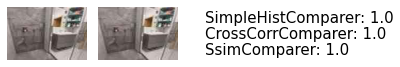

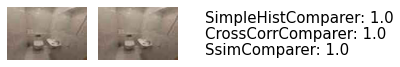

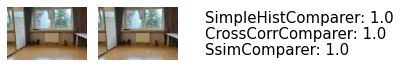

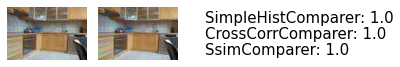

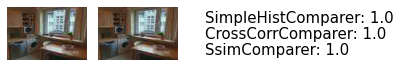

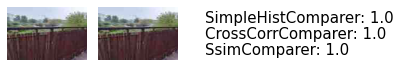

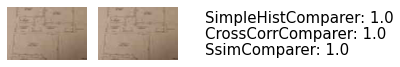

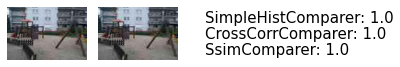

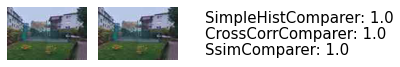

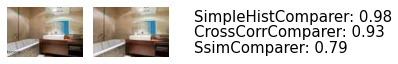

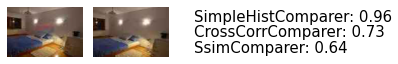

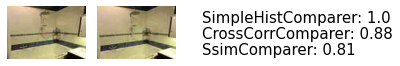

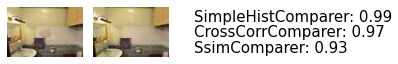

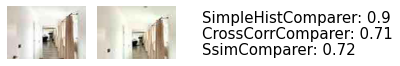

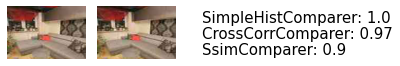

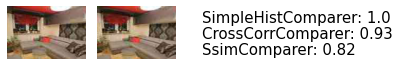

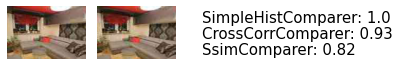

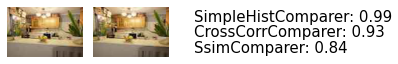

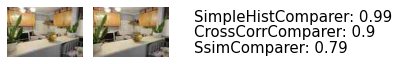

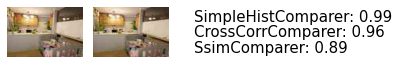

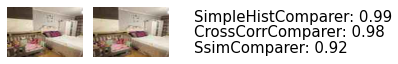

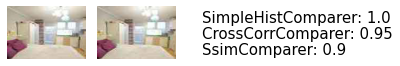

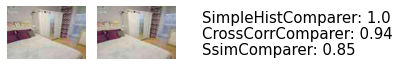

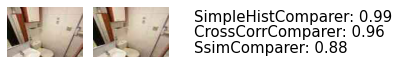

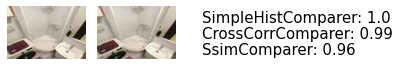

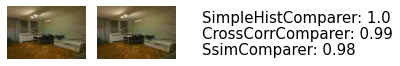

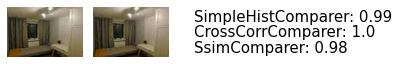

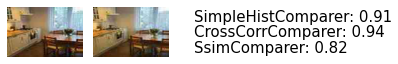

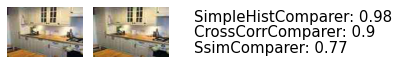

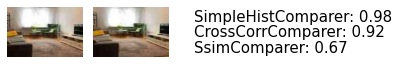

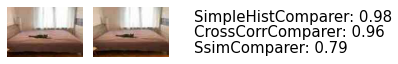

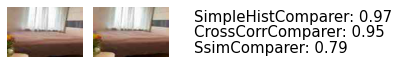

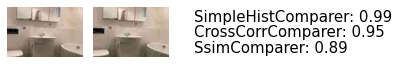

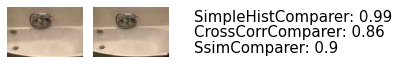

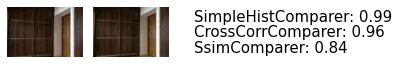

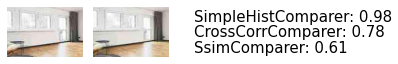

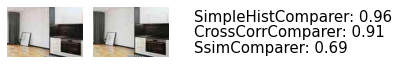

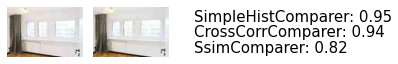

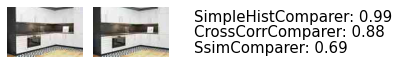

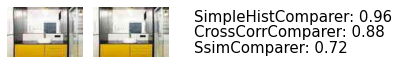

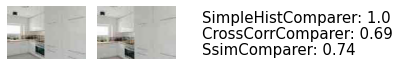

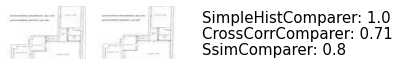

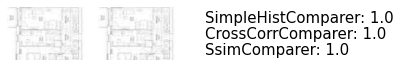

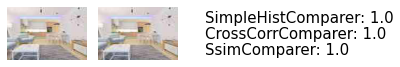

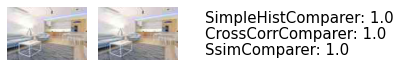

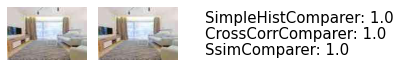

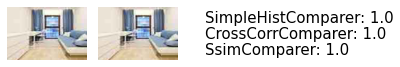

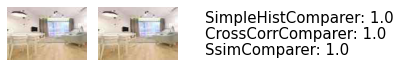

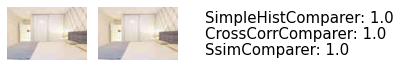

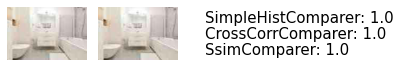

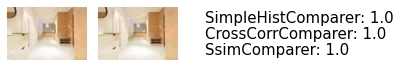

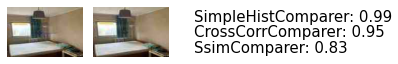

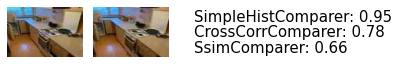

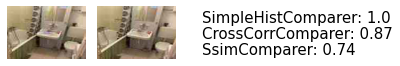

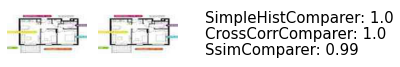

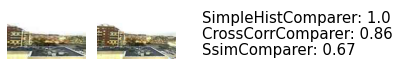

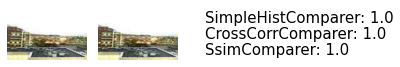

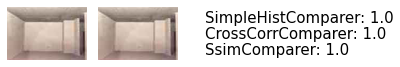

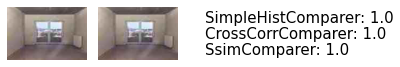

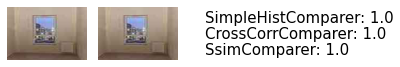

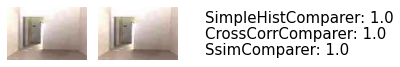

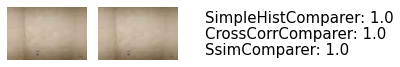

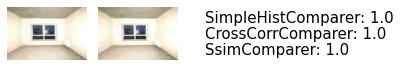

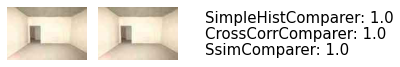

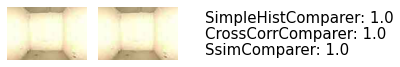

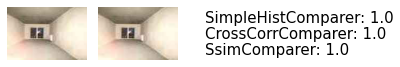

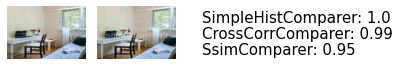

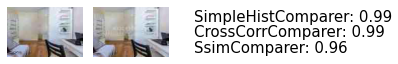

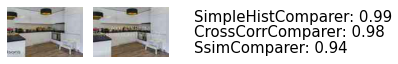

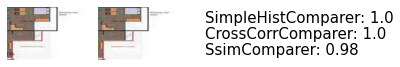

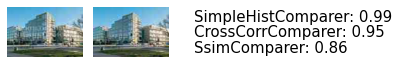

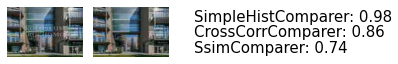

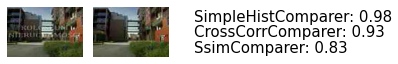

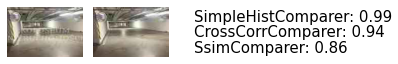

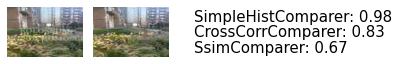

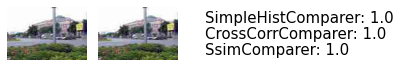

In [7]:
for match in ImageMatch.objects.all():
    img1 = bytes_to_images(match.post_1.photos_bytes)[match.img_pos_1]
    img2 = bytes_to_images(match.post_2.photos_bytes)[match.img_pos_2]
    display_img_comp(img1, img2, **json.loads(match.details_json))

### Results of matching

In [17]:
multi_flats = set(fp.flat for fp in FlatPost.objects.filter(is_original_post=False) if fp.flat is not None)

In [9]:
engine = ImageMatchingEngine(stop_early=True)

In [11]:
f = list(multi_flats)[0]
fposts = f.flatpost_set.all()
fp1 = fposts[0]
fp2 = fposts[1]
images1 = bytes_to_images(fp1.photos_bytes)
images2 = bytes_to_images(fp2.photos_bytes)


Flat
	Dwa pokoje 56m Służew ciche nowoczesny blok, 57.0 m2, district:mokotow


/Users/jakubtlalka/.virtualenvs/m3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


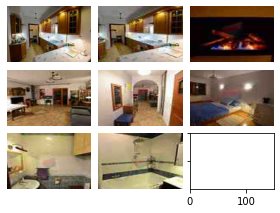

	⌦MOKOTÓW, 2 POKOJE, ŚWIETNA LOKALIZACJA, PRZESTRONNE, 56.0 m2, district:mokotow


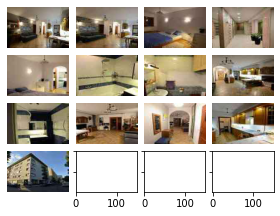

Flat
	Przytulne, 2 pokoje mieszkanie wraz z meblami, Mokotów, Służewiec, 37.0 m2, district:mokotow


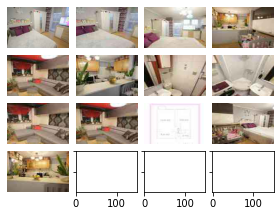

	Dwa pokoje na Mokotowie!, 37.0 m2, district:mokotow


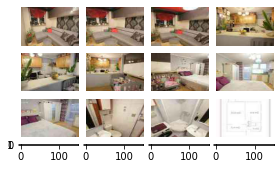

Flat
	⌦OCHOTA, 3 POKOJE, ŚWIEŻO WYKOŃCZONE, 48.0 m2, district:ochota


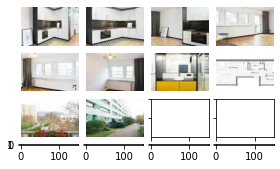

	3 pokojowe mieszkanie na Ochocie, 48.0 m2, district:ochota


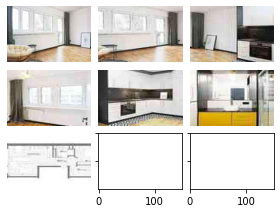

Flat
	M3 Bezpieczne wysoki standard na URSYNOWIE, 54.0 m2, district:mokotow


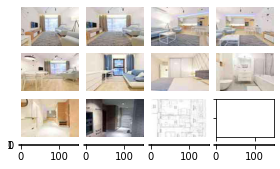

	M3 wysoki standard dostępne od zaraz na MOKOTOWIE, 54.0 m2, district:mokotow


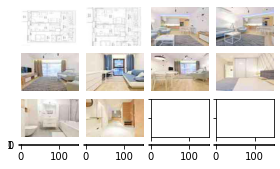

Flat
	⌦ŚRÓDMIEŚCIE, 2 POKOJE, PRZYTULNE, GOTOWE DO WPROWADZENIA, 46.0 m2, district:srodmiescie


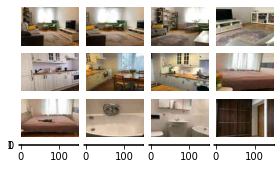

	W pełni wyposażone 2 pokoje w Centrum Warszawy!, 45.0 m2, district:srodmiescie


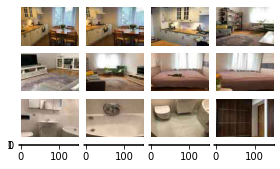

Flat
	Idealne dla rodziny, 3 pokoje Rakowiec, 50.0 m2, district:ochota


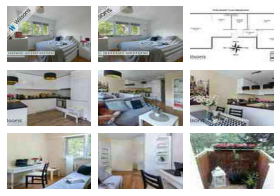

	3 pokojowe przy Racławickiej., 50.0 m2, district:ochota


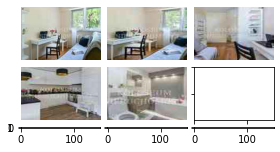

Flat
	Dwupoziomowe mieszkanie 5-pokojowe!Mokotów, 102.0 m2, district:mokotow


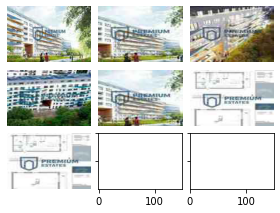

	Piękny 2-poz. apartament Mokotów-Stegny, 102.0 m2, district:mokotow


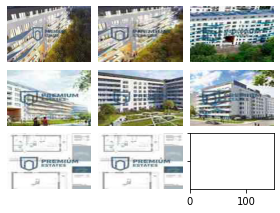

Flat
	3 pokojowe na Mokotowie -OKAZJA !!!, 56.0 m2, district:mokotow


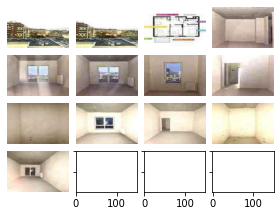

	3 pokojowe na Mokotowie-SUPER CENA! NOWY BLOK!, 56.0 m2, district:mokotow


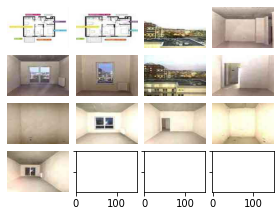

Flat
	BEZPOŚREDNIO 2 pokoje z oddzielną kuchnią na pięknym zielonym osiedlu, 57.0 m2, district:ochota


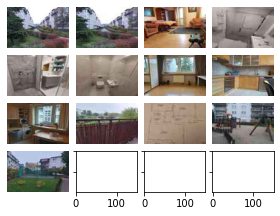

	BEZPOŚREDNIO 2 pokoje z oddzielną kuchnią na pięknym zielonym osiedlu, 57.0 m2, district:ochota


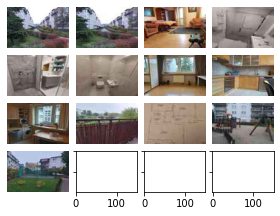

Flat
	3 pokoje po remoncie, przy Metrze!, 50.0 m2, district:mokotow


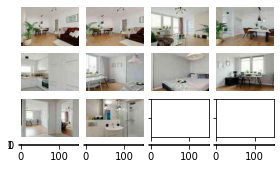

	LUKSUSOWE 3 POKOJE - TUŻ PRZY METRZE WIERZBNO  , 50.0 m2, district:mokotow


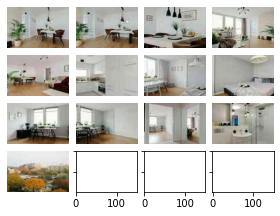

Flat
	Trzypokjowe mieszkanie z balkonem, 43.0 m2, district:mokotow


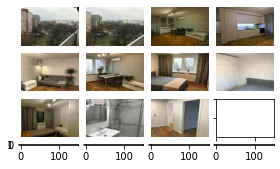

	Piękne 3-pokojowe 200m od Galerii Mokotów, 43.0 m2, district:mokotow


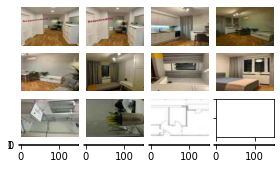

Flat
	EXCLUSIVE 2 pokoje, zabytkowa KAMIENICA – 1935 rok, PRESTIŻOWA LOKALIZACJA!, 44.0 m2, district:mokotow


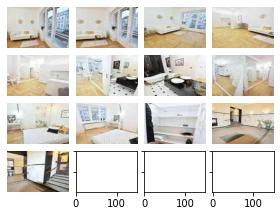

	EXCLUSIVE 2 pokoje, zabytkowa KAMIENICA – 1935 rok, PRESTIŻOWA LOKALIZACJA! , 44.0 m2, district:zoliborz


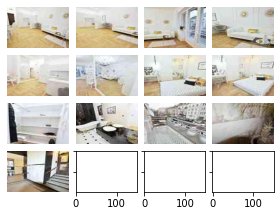

Flat
	2 pokoje WYSOKI STANDARD! Ostatnie piętro !, 62.0 m2, district:mokotow


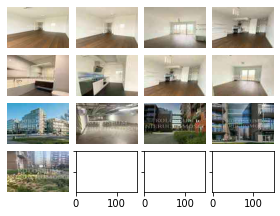

	Apartament Mokotów  Qbik, garaż, komórka *** piękny widok panorama Warszawy ****, 62.0 m2, district:mokotow


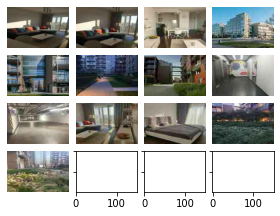

Flat
	Do remontu trzy pokoje przy Broniewskiego., 48.0 m2, district:zoliborz


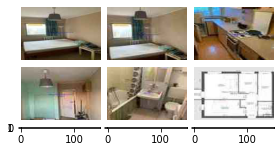

	Trzypokojowe mieszkanie na Żoliborzu!, 48.0 m2, district:bielany


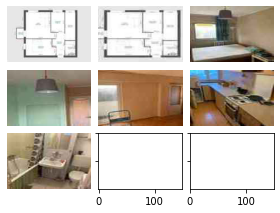

Flat
	Lux. apartament zanurzony w zielonym Śródmieściu, 69.0 m2, district:srodmiescie


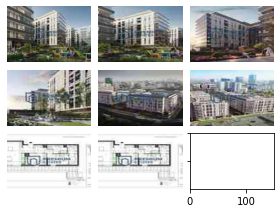

	Lux. apartament zanurzony w zielonym Śródmieściu, 70.0 m2, district:srodmiescie


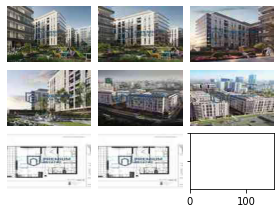

In [18]:
for flat in multi_flats:
    print("Flat")
    for fp in flat.flatpost_set.all():
        print(f"\t{fp.heading}, {fp.size_m2} m2, district:{fp.district}")
        display_post_images(fp)

In [157]:
f = list(multi_flats)[0]

In [158]:
f.flatpost_set.all()

<QuerySet [<FlatPost: 
	Dwupoziomowe mieszkanie 5-pokojowe!Mokotów
	https://www.gumtree.pl/a-mieszkania-i-domy-sprzedam-i-kupie/mokotow/dwupoziomowe-
	mieszkanie-5+pokojowe-mokotow/1008825771120911437600009
	 id: 2f45c886-3153-47ba-9432-6c4e378f94f2>, <FlatPost: 
	Piękny 2-poz. apartament Mokotów-Stegny
	https://www.gumtree.pl/a-mieszkania-i-domy-sprzedam-i-kupie/mokotow/piekny-2+poz-apartament-
	mokotow+stegny/1008825774010911437600009
	 id: a04389a8-69fa-4d84-a76d-499265d5f233>]>

### Converting to bytes

In [ ]:
img_bytes_a = BytesIO()
im_a.resize((150, 100), Image.ANTIALIAS).save(img_bytes_a, format="JPEG", optimize=True, quality=40)
sys.getsizeof(img_bytes_a.getvalue())

In [ ]:
img_bytes_b = BytesIO()
im_x.resize((150, 100), Image.ANTIALIAS).save(img_bytes_b, format="JPEG", optimize=True, quality=40)
sys.getsizeof(img_bytes_b.getvalue())

In [ ]:
Image.open(img_bytes).resize((150, 100))

In [ ]:
type(img_bytes.getvalue())

In [ ]:
b'$!%'.join([]) == b''

In [ ]:
sys.getsizeof(joined_b)

In [ ]:
im = Image.open(BytesIO(joined_b.split(b'$!%')[1]))

In [ ]:
Image.open(img_bytes_a)